# Smart Water Quality Monitoring System - EDA/ MulticlassClassification Analysis

1. [Preparation](#Preparation)  

2. [Dataset Loading](#Dataset-Loading)  

3. [Descriptive Statistics](#Descriptive-Statistics)

4. [Visualizations](#Visualizations)
    -  [4.1. Data Visualizations](#Data-Visualizations)
    -  [4.2. Correlation Analysis](#Correlation-Analysis)
    
5. [Data Preparation](#Data-Preparation)

6. [Feature Selection](#Feature-Selection)
    -  [6.1. DataSet Preparation](#DataSet-Preparation)
    -  [6.2. Reduced Feature Elimination (RFE)](#Reduced-Feature-Elimination-RFE)
    -  [6.3. Model Feature Importance](#Model-Feature-Importance)
    -  [6.4. Factor Analysis](#Factor-Analysis)

7. [Algorithm Evaluation](#Algorithm-Evaluation)
    -  [7.1 Train/Test Dataset Preparation](#Train-Test-Dataset-Preparation)
    -  [7.2. Test Options and Evaluation Metrics](#Test-Options-Evaluation-Metrics)
    -  [7.3 Evaluate Classification Algorithms](#Evaluate-Classification-Algorithms)
    -  [7.4 Evaluate Cross-Validation](#Evaluate-Cross-Validation)
    -  [7.5 Evaluate Algorithm Performance](#Evaluate-Algorithm-Performance)
    -  [7.6 Test Dataset Prediction Performance](#Test-Dataset-Prediction-Performance)
    -  [7.7 Model Tuning](#Model-Tuning)

## 1. Preparation <a class="anchor" id="Preparation"></a>

### 1.1 Load Libraries

In [1]:
# Load libraries
from azure.storage.blob import BlockBlobService
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from pandas import set_option
from matplotlib import pyplot
import scipy
from scipy.stats import spearmanr
from scipy import interp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
from matplotlib import pylab
from pylab import *
from pylab import rcParams
import seaborn as sb

from IPython.display import Markdown, display, HTML
from IPython.core.display import HTML
from pprint import pprint

import sklearn
from sklearn.preprocessing import scale 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import FactorAnalysis
from sklearn import datasets
from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

rcParams['axes.facecolor'] = 'white'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.linewidth'] = 1
rcParams['figure.figsize'] = (4,4)
rcParams['legend.fontsize'] = 10
rcParams['legend.handlelength'] = 2

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### 1.2 Suppress warning messages

In [2]:
import sys
import time
import warnings
from IPython.display import Markdown, display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### 1.3 Disable auto-scrolling

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 2. Dataset Loading  <a class="anchor" id="Dataset-Loading"></a>

In [4]:
from scipy import stats

#LOCALFILE is the file path    
STORAGEACCOUNTNAME= "smartwaterstorage"
STORAGEACCOUNTKEY= "5GGqEdDGjlqyKRjnLIFogG1LzeUlyQ3iwMBFyDgR7pdB4VPMtuUwvBNUyAss98wrNTWa8KNTe+L7DxMcEWyY5Q=="
LOCALFILENAME= "SW"    
CONTAINERNAME= "smart-water-db"
blob_service=BlockBlobService (account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
    
filenames = ['NoMedium', 'Tap_Water', 'Flour_Water', 'Soap_Water', 'Shampoo_Water', 'Sea_Water']
    
df_all =  pd.DataFrame()

for i, name in enumerate(filenames):
     BLOBNAME= "ModelTraining/Dataset/" + name + ".csv"
     blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME)   

     # Read Blob storage data
     dataframe_blobdata = pd.read_csv(LOCALFILENAME, header=0) 
     #dataframe_blobdata = pd.read_csv("Dataset/" + name + ".csv", header=0) 
    
     # Group sensor data readings by 'datetime' column   
     df_sensordata = dataframe_blobdata[['datetime','sensor','value']].groupby(['datetime','sensor']).value.first().unstack().dropna()

     # Split accelerometer reading 'ACC' column to 3-axis columns ()'ACC_X', 'ACC_Y', 'ACC_Z')   
     df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']] = df_sensordata['ACC'].str.split(';', expand=True)

     # Convert 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND' columns to float datatype
     df_sensordata[['BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']] = df_sensordata[['BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']].astype(float)

     # Convert 'ACC_X', 'ACC_Y', 'ACC_Z' columns to integer datatype
     df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']] = df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']].astype(int)

     # Convert 'DATE' column to date datatype 
     df_sensordata['DATE'] =  pd.to_datetime(df_sensordata['DATE'], format='%y-%m-%d')

     # Convert 'TIME' column to time datatype 
     df_sensordata['TIME'] =  pd.to_datetime(df_sensordata['TIME'], format='%H-%M-%S').dt.time

     df_sensordata['DT'] = pd.to_datetime(df_sensordata.DATE.astype(str)+' '+df_sensordata.TIME.astype(str))

     # Reorder columns
     df_sensordata= df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']]

     # Remove Outliers
     df_sensordata = df_sensordata[(np.abs(stats.zscore(df_sensordata)) < 2).all(axis=1)]

     # Reset index column   
     df_sensordata.reset_index(drop = True, inplace = True)
    
     if(i == 0):
         df_sensordata['class'] = 0
         df_all = pd.DataFrame(data=None, columns=df_sensordata.columns, index=df_sensordata.index)
         df_all = pd.concat([df_all, df_sensordata], axis=0)
     else:
         df_sensordata['class'] = int(i)
         df_all = pd.concat([df_all, df_sensordata], axis=0)

df_all = df_all.dropna()
df_all[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'class']] = df_all[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'class']].astype(int)

In [5]:
df_all.head(5)

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND,class
0,-2,-5,1023,7,26.42,5.51,138.5,0.011,0.7,0
1,0,-4,1020,7,26.42,5.46,138.1,0.013,0.7,0
2,-5,-8,1023,7,26.42,5.45,138.1,0.016,0.7,0
3,-6,-5,1019,7,26.41,5.43,138.1,0.017,0.7,0
4,-5,-4,1019,7,26.41,5.46,137.7,0.017,0.7,0


## 3. Descriptive Statistics <a class="anchor" id="Descriptive-Statistics"></a>

### 3.1. Check basic statistics

In [6]:
print('the size of the data is: %d rows and  %d columns' % df_all.shape)

the size of the data is: 967 rows and  10 columns


In [7]:
for col in df_all.columns:
     print(df_all[col].name, ':\t', df_all[col].dtype)

ACC_X :	 int64
ACC_Y :	 int64
ACC_Z :	 int64
BAT :	 int64
WT :	 float64
PH :	 float64
DO :	 float64
ORP :	 float64
COND :	 float64
class :	 int64


### 3.2. Check descriptive statistics for numerical features

In [8]:
class_unique = df_all['class'].unique()
df_features = df_all[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']]
class_names_map = {1:"Grade 1", 2:"Grade 2", 3:"Grade 3", 4:"Grade 4", 5:"Grade 5", 0:"No Medium"}
for classtype in class_unique:
    df_type = df_features[df_all['class'] == classtype]
    display(Markdown("**" + "Name: " + class_names_map[classtype] + "**"))
    display(HTML(pd.DataFrame(df_type.describe()).to_html()))

**Name: No Medium**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,2.080000e+02
mean,-7.596154,-7.067308,1017.850962,6.644231,25.763654,5.285913,137.989904,0.012769,7.000000e-01
std,3.498845,3.513300,3.514208,0.479901,0.296702,0.086573,0.168952,0.002372,4.451606e-16
min,-16.000000,-16.000000,1010.000000,6.000000,25.270000,5.030000,137.500000,0.007000,7.000000e-01
25%,-10.000000,-9.000000,1015.000000,6.000000,25.527500,5.220000,137.900000,0.012000,7.000000e-01
50%,-8.000000,-7.000000,1018.000000,7.000000,25.725000,5.300000,138.000000,0.013000,7.000000e-01
75%,-5.000000,-5.000000,1020.000000,7.000000,25.970000,5.352500,138.100000,0.014000,7.000000e-01
max,0.000000,3.000000,1025.000000,7.000000,26.420000,5.510000,138.500000,0.018000,7.000000e-01


**Name: Grade 1**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,0.663551,-5.700935,1018.570093,5.121495,24.536636,5.460187,38.793458,-0.061813,290.465421
std,2.437691,3.875942,4.300312,0.328239,0.174226,0.160312,31.382528,0.012627,47.402812
min,-5.000000,-13.000000,1008.000000,5.000000,24.320000,5.210000,10.600000,-0.077000,185.800000
25%,0.000000,-8.000000,1015.000000,5.000000,24.410000,5.330000,14.500000,-0.073500,255.900000
50%,0.000000,-6.000000,1019.000000,5.000000,24.480000,5.490000,17.800000,-0.065000,312.000000
75%,2.000000,-3.000000,1022.000000,5.000000,24.610000,5.560000,61.150000,-0.048000,329.000000
max,7.000000,1.000000,1029.000000,6.000000,24.980000,5.780000,97.300000,-0.044000,349.000000


**Name: Grade 2**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.904494,-6.837079,1016.966292,4.269663,24.249101,5.548764,4.208989,0.099090,243.412921
std,1.561139,3.358332,3.391413,0.445037,0.335315,0.137066,0.247080,0.000454,34.638516
min,-2.000000,-14.000000,1009.000000,4.000000,23.830000,5.200000,3.800000,0.098000,182.800000
25%,0.000000,-9.000000,1014.250000,4.000000,23.980000,5.490000,4.000000,0.099000,212.475000
50%,1.000000,-7.000000,1017.000000,4.000000,24.175000,5.570000,4.100000,0.099000,242.000000
75%,2.000000,-5.000000,1019.000000,5.000000,24.437500,5.657500,4.500000,0.099000,272.775000
max,4.000000,0.000000,1024.000000,5.000000,25.090000,5.730000,4.600000,0.102000,303.300000


**Name: Grade 3**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,144.000000,144.000000,144.000000,144.0,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.513889,-6.770833,1017.263889,5.0,24.339444,6.202986,70.790278,-0.060986,518.277083
std,2.788553,3.671319,3.606494,0.0,0.260564,0.103836,7.329472,0.004453,2.423680
min,-4.000000,-15.000000,1009.000000,5.0,23.810000,5.960000,63.700000,-0.071000,514.900000
25%,0.000000,-9.000000,1015.000000,5.0,24.157500,6.157500,66.975000,-0.065250,516.875000
50%,0.000000,-7.000000,1017.000000,5.0,24.325000,6.210000,67.700000,-0.060000,517.850000
75%,3.000000,-4.000000,1020.000000,5.0,24.542500,6.292500,72.325000,-0.057000,519.000000
max,7.000000,1.000000,1025.000000,5.0,24.890000,6.330000,93.800000,-0.054000,526.200000


**Name: Grade 4**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,162.00000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.00000,162.000000
mean,-1.62963,-10.820988,1025.061728,6.993827,28.531235,1.751605,0.047654,75.52284,212.724074
std,2.04875,2.948638,4.384744,0.078567,0.208219,0.301757,0.005825,2.46136,2.294384
min,-7.00000,-17.000000,1015.000000,6.000000,28.300000,1.380000,0.027000,67.30000,210.000000
25%,-3.00000,-13.000000,1022.000000,7.000000,28.350000,1.472500,0.047000,74.32500,210.925000
50%,-1.00000,-11.000000,1024.000000,7.000000,28.450000,1.745000,0.050000,75.60000,212.500000
75%,0.00000,-9.000000,1028.000000,7.000000,28.710000,1.930000,0.051000,77.00000,213.000000
max,3.00000,-4.000000,1035.000000,7.000000,28.980000,2.810000,0.053000,82.20000,219.600000


**Name: Grade 5**

sensor,ACC_X,ACC_Y,ACC_Z,BAT,WT,PH,DO,ORP,COND
count,168.000000,168.000000,168.000000,168.0,168.000000,168.000000,168.000000,168.000000,168.0
mean,-0.404762,-6.333333,1016.357143,1.0,23.205476,5.454881,72.194643,-0.013887,-5021.0
std,1.988705,3.086898,3.389462,0.0,0.106281,0.108230,27.355842,0.000430,0.0
min,-5.000000,-12.000000,1010.000000,1.0,23.050000,5.290000,11.700000,-0.015000,-5021.0
25%,-2.000000,-8.000000,1014.000000,1.0,23.110000,5.360000,40.175000,-0.014000,-5021.0
50%,0.000000,-7.000000,1016.000000,1.0,23.210000,5.440000,88.800000,-0.014000,-5021.0
75%,0.000000,-4.000000,1019.000000,1.0,23.270000,5.530000,94.000000,-0.014000,-5021.0
max,5.000000,0.000000,1024.000000,1.0,23.490000,5.670000,120.500000,-0.013000,-5021.0


### 3.3. Check class distribution

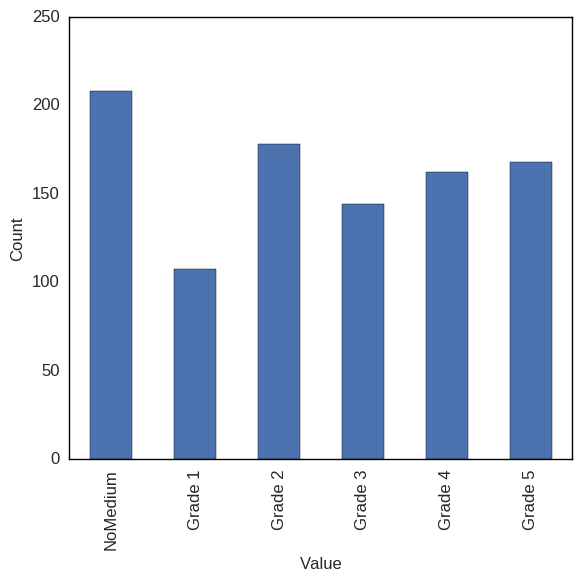

In [9]:
name_label = 'class'

plt.figure(figsize=(6,6))

ValDist = pd.value_counts(df_all[name_label].values, sort=False)
ax = ValDist.plot(kind='bar', title ="",legend=False, fontsize=12)
ax.set_xlabel("Value",fontsize=12)
ax.set_ylabel("Count",fontsize=12)
ax.set_xticklabels(['NoMedium', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
plt.tight_layout()
plt.show()

## 4. Visualizations <a class="anchor" id="Visualizations"></a>

### 4.1. Data Visualization <a class="anchor" id="Data-Visualizations"></a>

### 4.1.1 Line Plots by Class Type

**Water Type: No Medium**

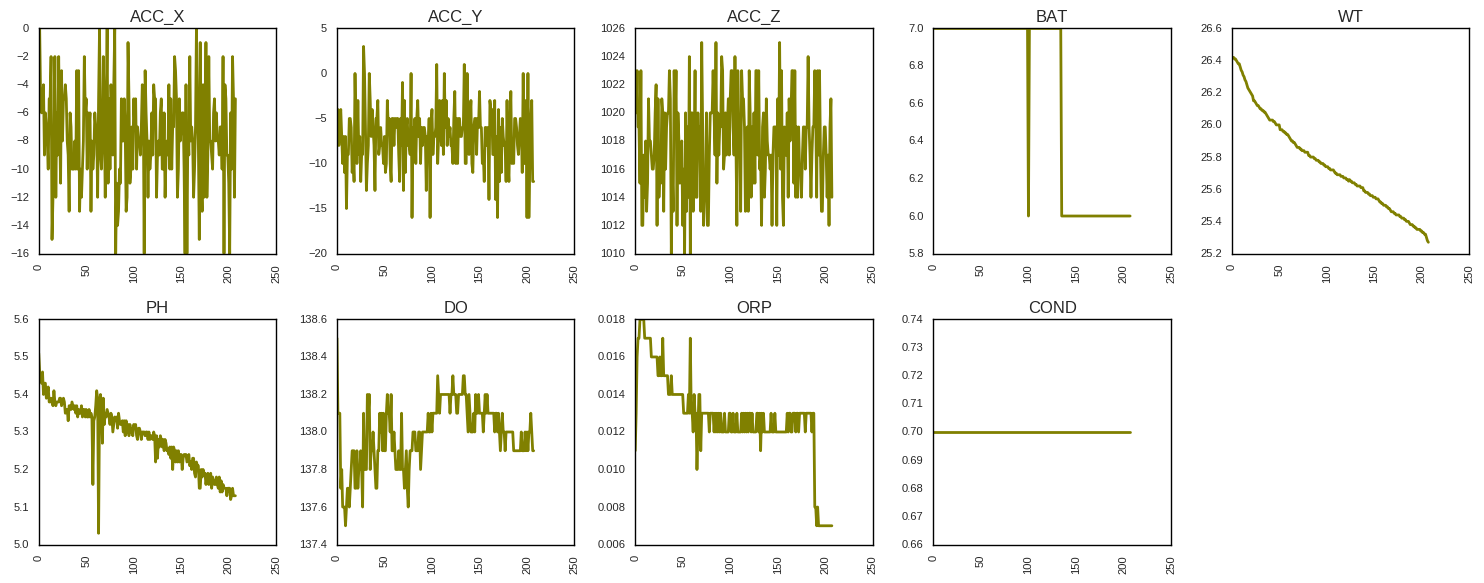

**Water Type: Grade 1**

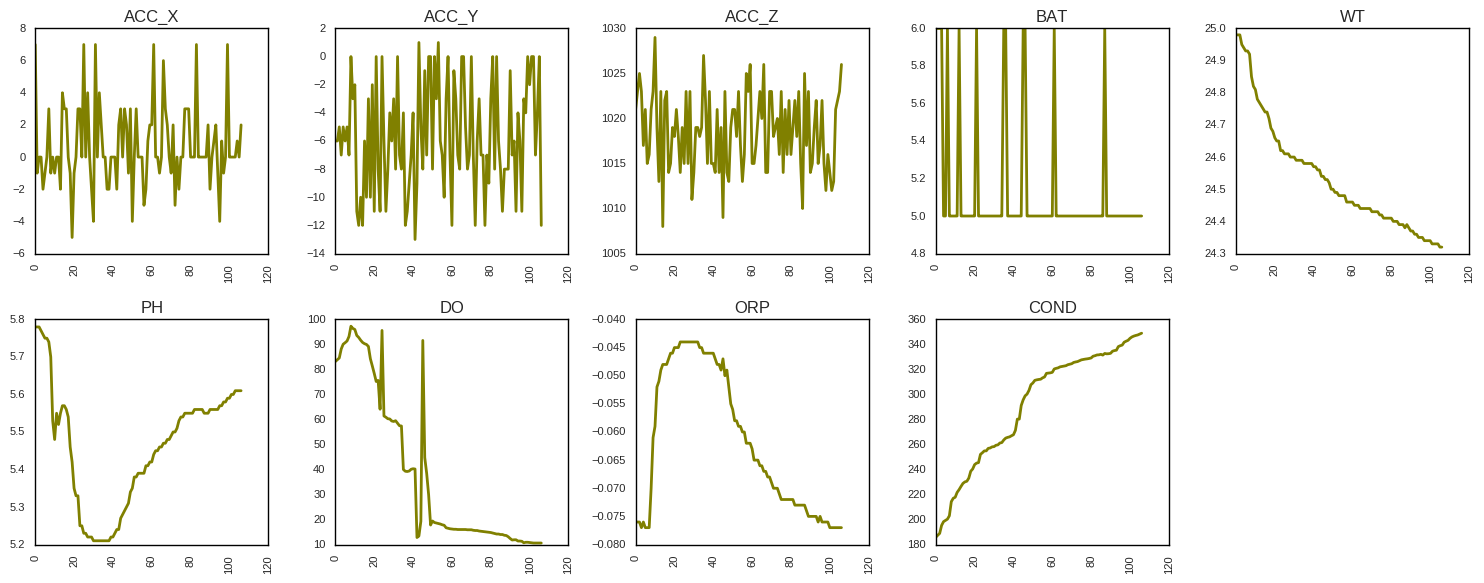

**Water Type: Grade 2**

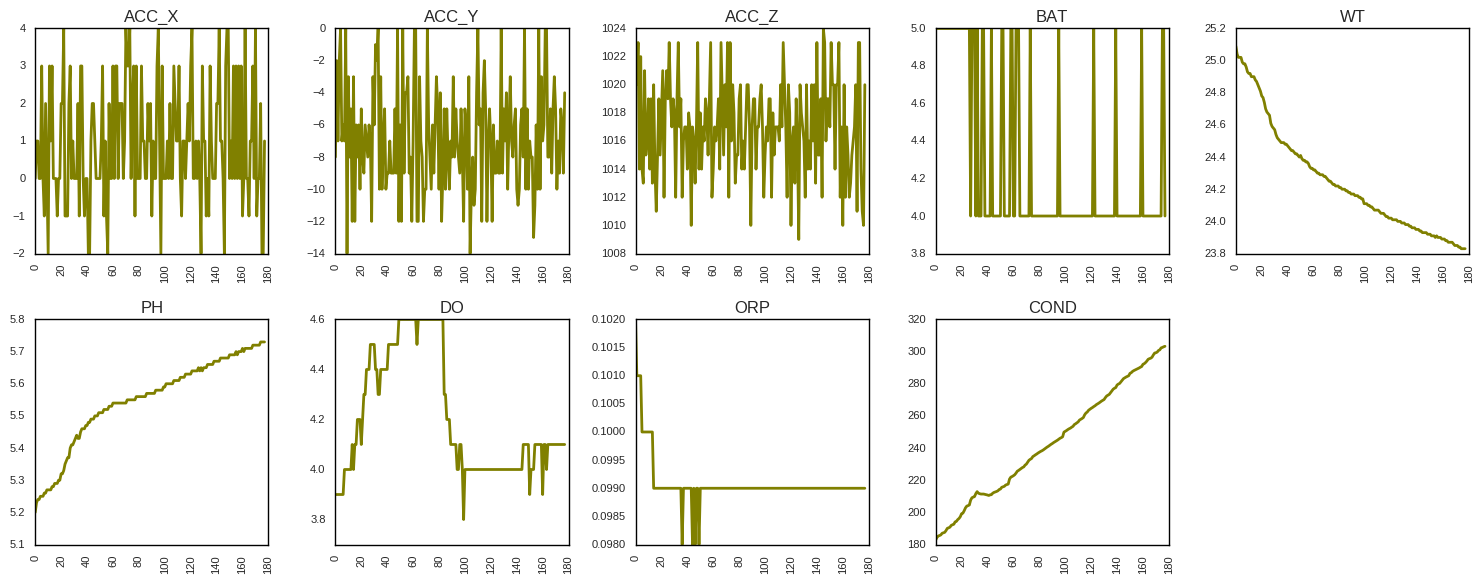

**Water Type: Grade 3**

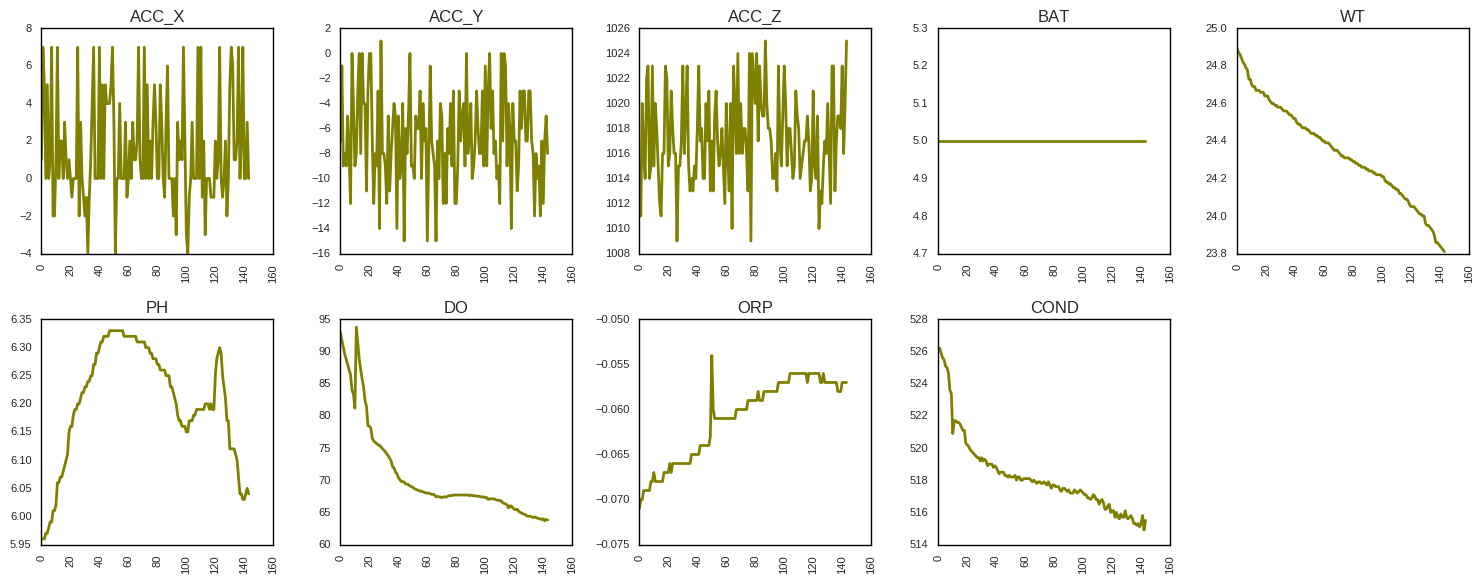

**Water Type: Grade 4**

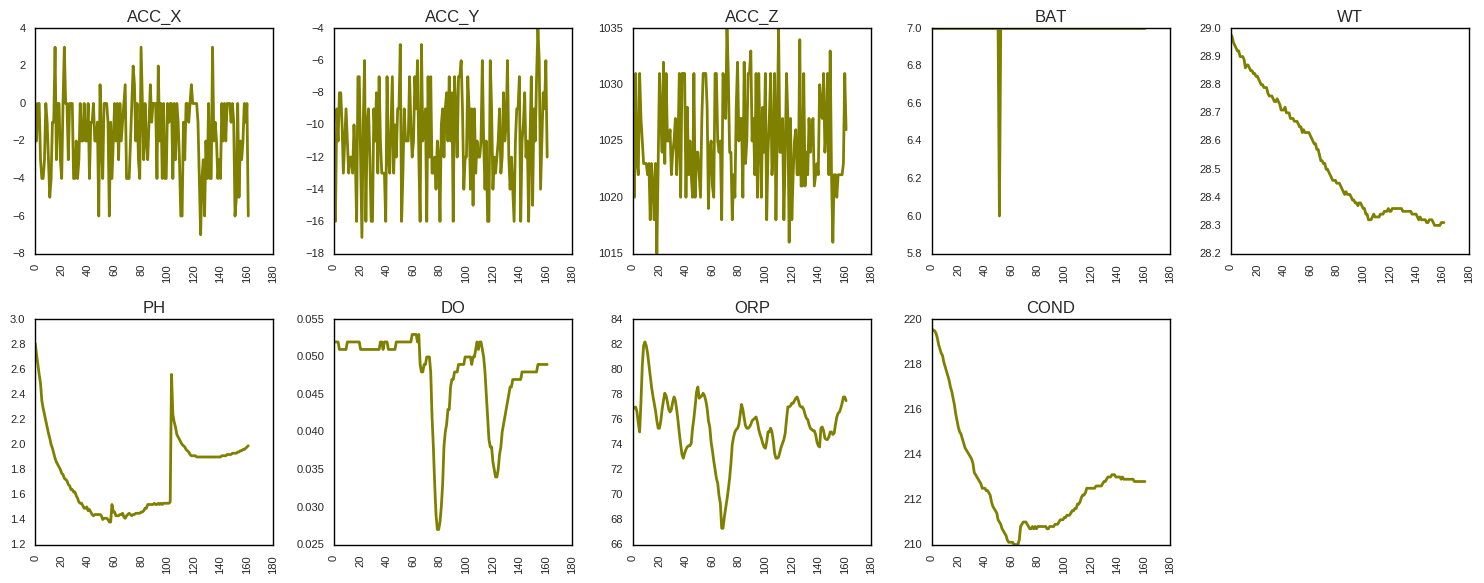

**Water Type: Grade 5**

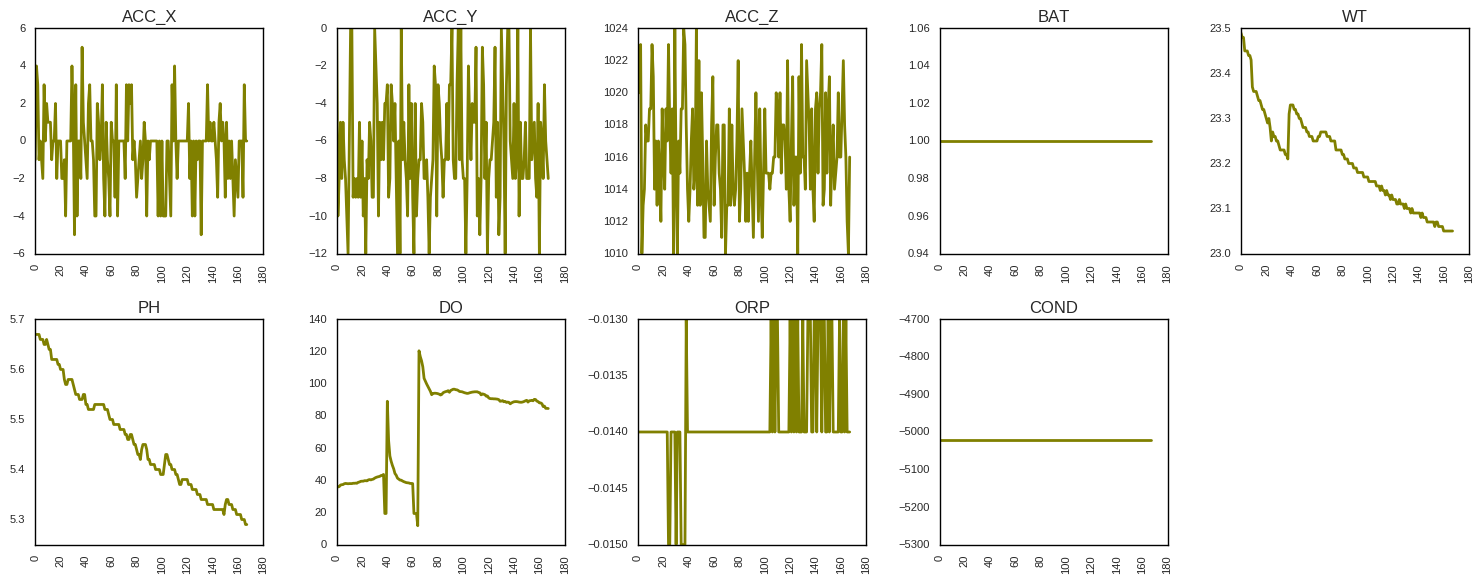

In [10]:
for classtype in class_unique:
    df_type = df_all[df_all['class'] == classtype]

    display(Markdown("**" + "Water Type: " + class_names_map[classtype] + "**"))
    
    num = 0
    fig = plt.figure(figsize=(15,6)) 

    for name in ['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']:
        num+=1
        plt.subplot(2,5, num)
        plt.plot( df_type[name], marker='', color='olive', linewidth=2)
        # Add title
        plt.title(name, loc='center', fontsize=12, fontweight=0)
        plt.tick_params(axis='both', which='both', labelsize=8)
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### 4.1.2 Line plots by features

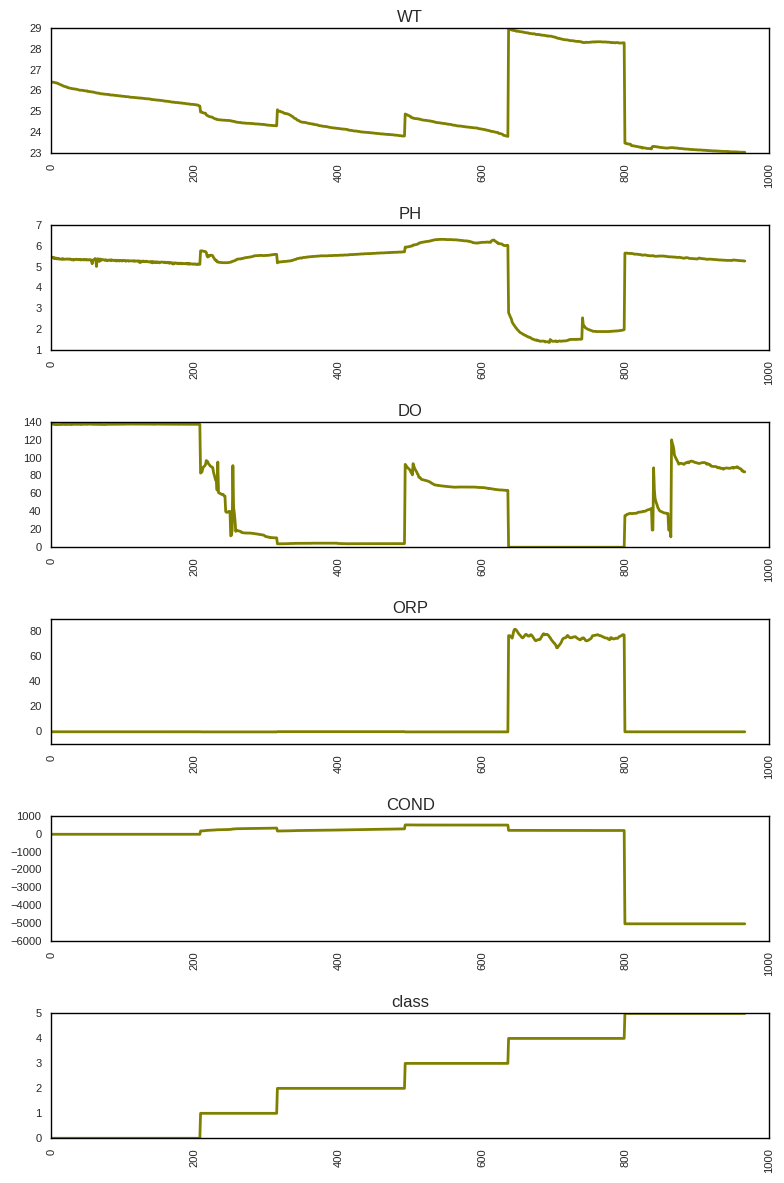

In [11]:
num = 0
fig = plt.figure(figsize=(8,12)) 

df_all_reindx = df_all.reset_index(drop=True)
names_features = ['WT', 'PH', 'DO', 'ORP', 'COND', 'class']

for name in names_features:
    num+=1
    plt.subplot(len(names_features),1, num)
    plt.plot( df_all_reindx[name], marker='', color='olive', linewidth=2)
    # Add title
    plt.title(name, loc='center', fontsize=12, fontweight=0)
    plt.tick_params(axis='both', which='both', labelsize=8)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 4.1.3 Boxplots by Features

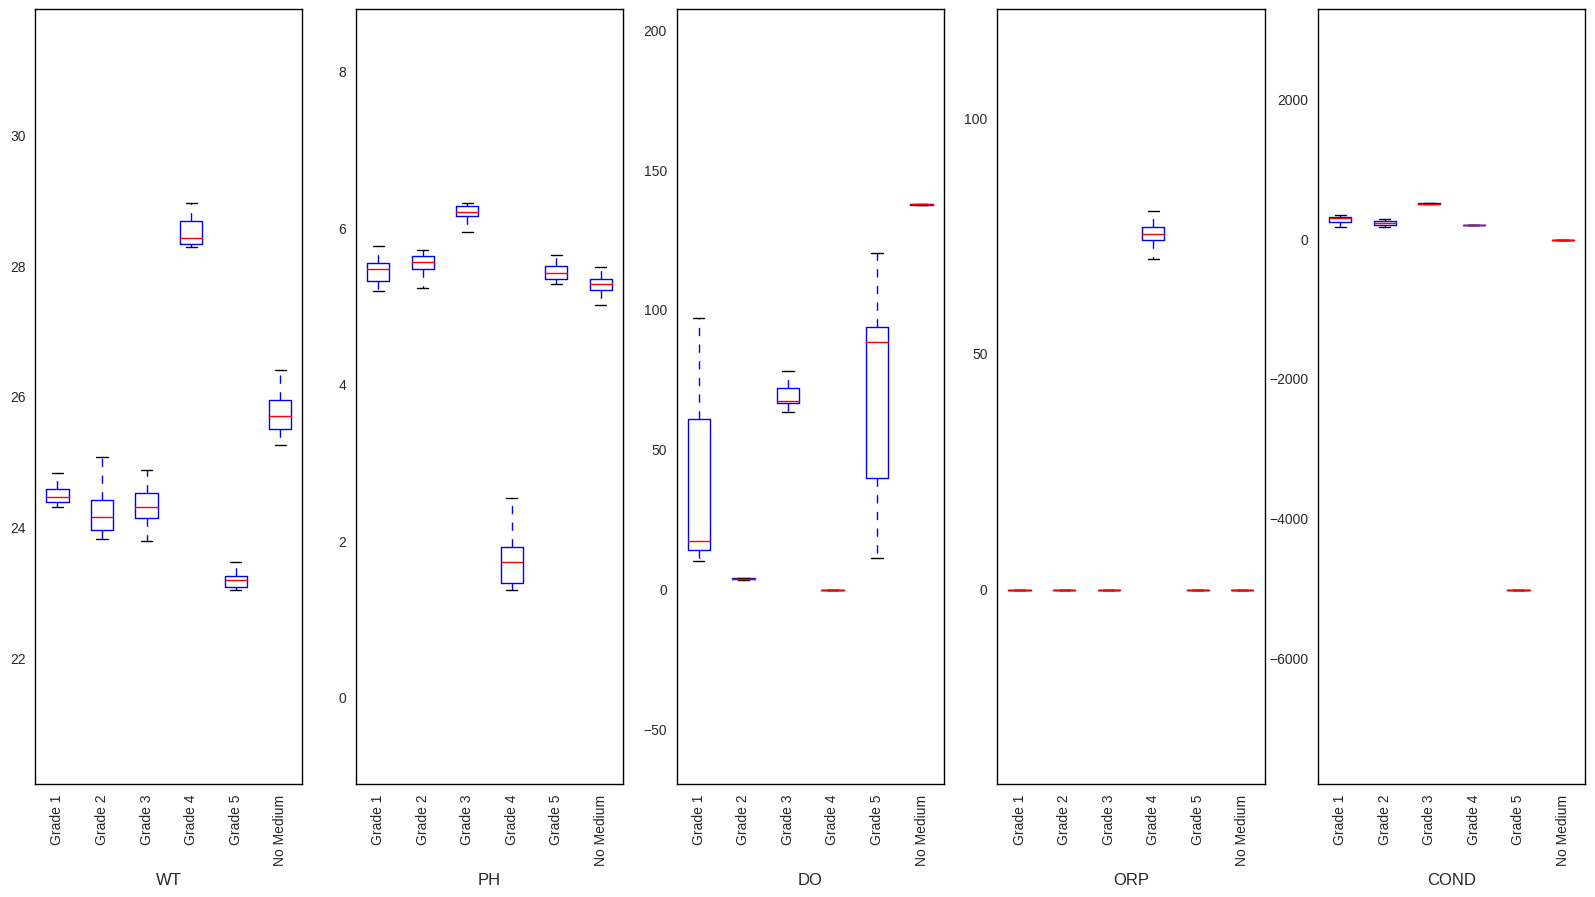

In [12]:
import random
data = {}
data['WT'] = {}
data['PH'] = {}
data['DO'] = {}
data['ORP'] = {}
data['COND'] = {}

clsTypeMap = {'Grade 1':1, 'Grade 2':2, 'Grade 3':3, 'Grade 4':4, 'Grade 5':5, 'No Medium':0}

for k,v in data.items():
    #upper = random.randint(0, 1000)
    for k2,v2 in clsTypeMap.items():
        df_type = df_all[df_all['class'] == clsTypeMap[k2]]
        v[k2] = df_type.ix[:, k].tolist()

fig, axes = plt.subplots(figsize=(20, 10), ncols=5, sharey=False)
fig.subplots_adjust(wspace=0.2)
plt.xticks(rotation=90)

for ax, name in zip(axes, ['WT', 'PH', 'DO', 'ORP', 'COND']):
    ax.boxplot([data[name][item] for item in ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5', 'No Medium']])
    ax.set_xticklabels(['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5', 'No Medium'], rotation = 90, va="top") 
    ax.set_xlabel(name, fontsize = 12)
    ax.margins(0.5)
plt.show()

__Observations__:

1. Grade 4 has much lower pH levels and higher ORP levels than the rest of the medium.
2. Grade 5 has much high conductivity level than the rest of the medium.

### 4.1.3 Histogram plots by Features

**Name: No Medium**

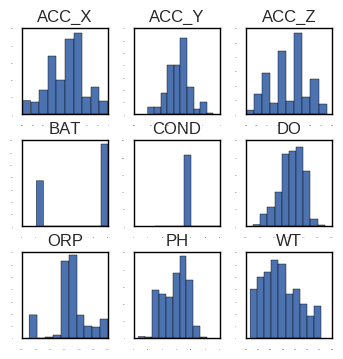

**Name: Grade 1**

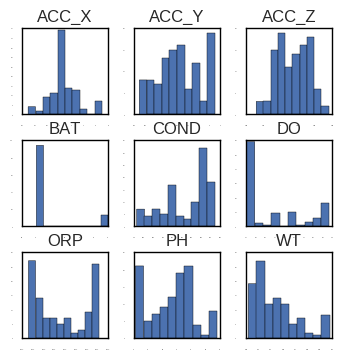

**Name: Grade 2**

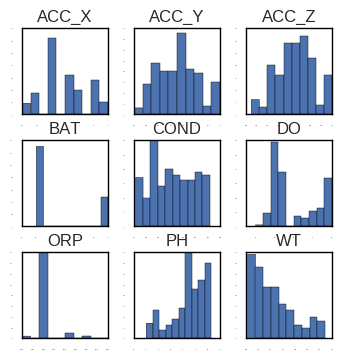

**Name: Grade 3**

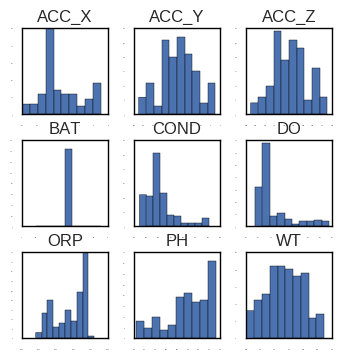

**Name: Grade 4**

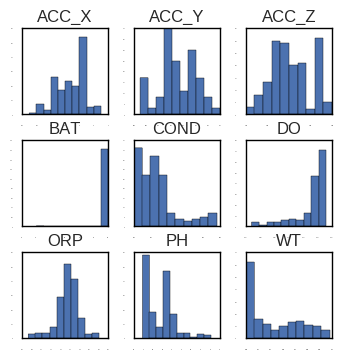

**Name: Grade 5**

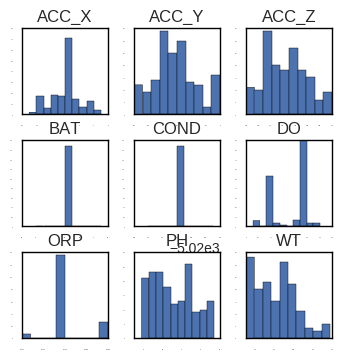

In [13]:
pyplot.rcParams['figure.figsize'] = [4, 4]
# histograms
for classtype in class_unique:
    df_type = df_features[df_all['class'] == classtype]
    display(Markdown("**" + "Name: " + class_names_map[classtype] + "**"))
    df_type.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
    pyplot.show()

### 4.2. Correlation Analysis <a class="anchor" id="Correlation-Analysis"></a>

### 4.2.1 Correlation Matrix Plot

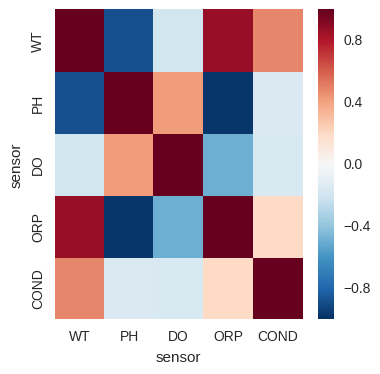

In [14]:
corr = df_all[['WT', 'PH', 'DO', 'ORP', 'COND']].corr()
sb.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

### 4.2.2 Top 15 Feature Correlations

In [15]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Top Absolute Correlations")
print('')
print(get_top_abs_correlations(df_all[['WT', 'PH', 'DO', 'ORP', 'COND']], 15))
print('')

Top Absolute Correlations

sensor  sensor
PH      ORP       0.973068
WT      PH        0.877850
        ORP       0.873558
        COND      0.490239
DO      ORP       0.488710
PH      DO        0.425376
ORP     COND      0.201313
WT      DO        0.195034
DO      COND      0.158004
PH      COND      0.147031
dtype: float64



### 4.2.3 Top Feature Correlation with Class

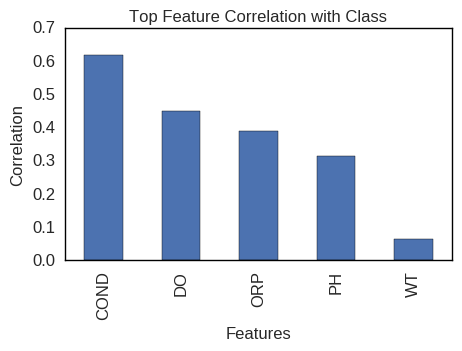

In [16]:
# correlation
corr_matrix = df_all[['WT','PH','DO','ORP','COND','class']].corr().abs()
corr_matrix = corr_matrix[:-1].iloc[:,-1].sort_values(ascending=False)

ax = corr_matrix.plot(kind='bar', title ="Top Feature Correlation with Class",figsize=(5,3),legend=False, fontsize=12)
ax.set_xlabel("Features",fontsize=12)
ax.set_ylabel("Correlation",fontsize=12)
plt.show()

## 5. Data Preparation <a class="anchor" id="Data-Preparation"></a>

### 5.1 Save cleaned dataset to File

In [17]:
df_all.to_csv(LOCALFILENAME, encoding='utf-8', index=False)
# Upload the created file, use local_file_name for the blob name
blob_service.create_blob_from_path(CONTAINERNAME + "/ModelTraining/Dataset", "SW_TrainingData.csv", LOCALFILENAME)

## 6. Feature Selection <a class="anchor" id="Feature-Selection"></a>

### 6.1. Dataset Preparation <a class="anchor" id="DataSet-Preparation"></a>

In [18]:
features_df = df_all[['WT','PH','DO','ORP','COND']]
class_df = df_all["class"]

feature_labels = np.array(list(features_df))

X = features_df.values
Y = class_df.values

### 6.2. Reduced Feature Elimination (RFE) <a class="anchor" id="Reduced-Feature-Elimination-RFE"></a>

Optimal number of features : 3


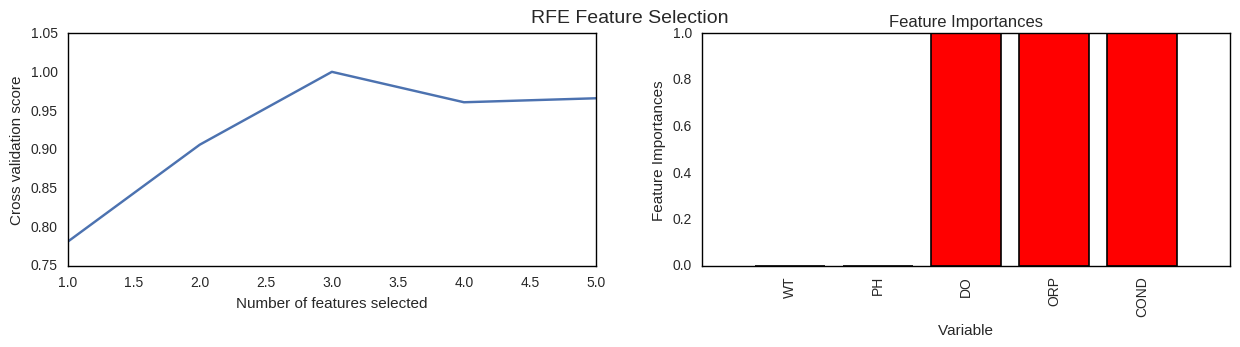

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def evaluateFeatureImportances_RFE(title, model, X, Y, feature_labels):
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    # Create the RFE object and compute a cross-validated score.
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
                  scoring='accuracy')
    rfecv.fit(X, Y)

    ImptFeatureQqty = rfecv.n_features_
    print("Optimal number of features : %d" % ImptFeatureQqty)
    #print(rfecv.get_support(indices=True))

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(15,3))
    plt.suptitle(title)
    plt.subplot(121)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

    feature_index_by_importance = rfecv.get_support(indices=True)
    feature_importances = rfecv.ranking_
    feature_importances = feature_importances*1
    
    # Sort the values and flip them
    index_sorted = np.argsort(feature_importances)

    Factors = []
    FeatureImportances = [0 for x in range(len(feature_labels))]

    for i in range(0, len(feature_labels)):
        if(i in feature_index_by_importance):
            FeatureImportances[i] = feature_importances[i]
        else:
             FeatureImportances[i] = 0
        Factors.append(feature_labels[i])

    idx = [i for i, _ in enumerate(Factors)]

    plt.subplot(122)
    plt.xlabel('Variable'); 
    plt.ylabel('Feature Importances'); 
    plt.title('Feature Importances');
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=90)
    plt.bar(idx,FeatureImportances, align='center', orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
    plt.xticks(idx, Factors)
    plt.show()

    return index_sorted, ImptFeatureQqty

model = RandomForestClassifier()
RFClassifier_feature_index_by_importance_RFE, RFClassifier_Impt_Feature_Qty_RFE = evaluateFeatureImportances_RFE("RFE Feature Selection", model, X, Y, feature_labels)

### 6.3. Model Feature Importance <a class="anchor" id="Model-Feature-Importance"></a>

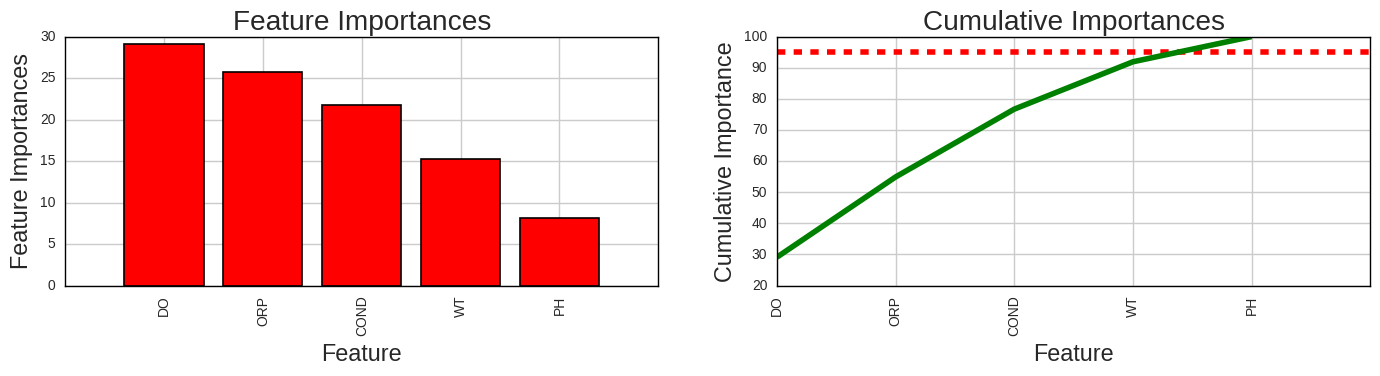

Number of features for 95% importance: 5


In [20]:
rcParams['axes.facecolor'] = 'white'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.linewidth'] = 1
rcParams['figure.figsize'] = (4,4)
rcParams['figure.facecolor'] = 'white'
rcParams['legend.fontsize'] = 10
rcParams['legend.handlelength'] = 2

def evaluateFeatureImportances(title, model, X, Y):
    model.fit(X, Y)

    # Create a numpy array based on the model's feature importances
    importance = model.feature_importances_
    # Sort the feature labels based on the feature importance rankings from the model
    feature_index_by_importance = importance.argsort()[::-1]

    Factors = []
    FeatureImportances = []
    # Print each feature label, from most importance to least important (reverse order)
    for i, index in enumerate(feature_index_by_importance):
        #print("{} - {:2f}%".format(feature_labels[index], (importance[index] * 100.0)))
        Factors.append(feature_labels[index])
        FeatureImportances.append(importance[index] * 100.0)

    idx = [i for i, _ in enumerate(Factors)]
    
    plt.figure(figsize=(15,3))
    plt.suptitle(title)
    plt.subplot(121)
    # Axis labels and title
    plt.xlabel('Feature'); 
    plt.ylabel('Feature Importances'); 
    plt.title('Feature Importances');
    plt.xticks(rotation=90)
    plt.bar(idx,FeatureImportances, align='center', orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
    plt.xticks(idx, Factors)
    
    # Cumulative importances
    cumulative_importances = np.cumsum(FeatureImportances)

    plt.subplot(122)
    # Make a line graph
    plt.plot(idx, cumulative_importances, 'g-')

    # Draw line at 95% of importance retained
    plt.hlines(y = 95, xmin=0, xmax=len(FeatureImportances), color = 'r', linestyles = 'dashed')

    # Format x ticks and labels
    plt.xticks(idx, Factors, rotation = 'vertical')

    # Axis labels and title
    plt.xlabel('Feature'); 
    plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Importances');
    plt.show()
    # Find number of features for cumulative importance of 95%
    # Add 1 because Python is zero-indexed
    ImptFeatureQqty = np.where(cumulative_importances > 95)[0][0] + 1
    print('Number of features for 95% importance:', ImptFeatureQqty)
    #print(feature_index_by_importance)
    return feature_index_by_importance, ImptFeatureQqty

model = RandomForestClassifier()
RFClassifier_feature_index_by_importance, RFClassifier_Impt_Feature_Qty = evaluateFeatureImportances(
                                                                    "", model, X, Y)

### 6.4. Factor Analysis <a class="anchor" id="Factor-Analysis"></a>

In [21]:
feature_names = list(features_df)

pd.options.display.float_format = '{:.4f}'.format

factor = FactorAnalysis(n_components=20, random_state=101).fit(features_df)

df_factor = pd.DataFrame(factor.components_, columns=feature_names)

display(HTML(df_factor.to_html()))

ImptFeatureQty = len(df_factor.loc[~(df_factor==0).all(axis=1)]) + 1

print("Number of important features: ", ImptFeatureQty)

,WT,PH,DO,ORP,COND
0,-0.8498,0.2151,8.3927,-5.6838,-1995.6224
1,-0.4055,0.7676,51.8879,-16.3169,0.2669
2,1.4047,-1.1852,7.2845,22.2898,-0.0383
3,0.1875,-0.1530,-0.0159,-0.1494,-0.0003
4,0.0000,0.0000,-0.0000,0.0000,-0.0000


Number of important features:  5


## 7. Algorithm Evaluation <a class="anchor" id="Algorithm-Evaluation"></a>

### 7.1. Train/Test Dataset Preparation <a class="anchor" id="Train-Test-Dataset-Preparation"></a>

In [22]:
# Standardize the labels generated by the models
array = df_all.values
X = array[:,4:9]
Y = array[:,9]
Y = Y.astype('int')

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split (X, Y, test_size=validation_size, random_state=seed)

### 7.2. Test Options and Evaluation Metrics <a class="anchor" id="Test-Options-Evaluation-Metrics"></a>

In [23]:
num_folds = 10
seed = 7
scoring = 'accuracy'

### 7.3. Evaluate Classification Algorithms <a class="anchor" id="Evaluate-Classification-Algorithms"></a>

In [24]:
# Evaluate Classification Algorithms
def evaluate_algos(classifiers, X_train, Y_train, X_validation, Y_validation):
    score_list = []
    metrics_list = pd.DataFrame(columns=('Name', 'Accuracy', 'Precision', 'Recall'))
    
    for i, (name, algo) in enumerate(classifiers.items()):
        model = algo
        model.fit(X_train, Y_train)

        # make predictions for test data
        y_pred = model.predict(X_validation)

        p,r,f,s = precision_recall_fscore_support(Y_validation, y_pred, average='macro')
        
        predictions = [round(value) for value in y_pred]

        # evaluate predictions
        accuracy = accuracy_score(Y_validation, predictions)
        cm = confusion_matrix(Y_validation, predictions)
        cr = classification_report(Y_validation, predictions)
        tfpn = cm.ravel()

        score_list.append([name, accuracy * 100.0, cm, cr, p, r])
        metrics_list = metrics_list.append([{'Name': name, 'Accuracy' : accuracy * 100.0, 
                                           'Precision' : p, 'Recall' : r}], ignore_index=True)

    # Add Azure Algorithm Scores    
    for i, row in dataframe_Azure_metrics.iterrows():
        score_list.append([row['Algorithm'], row['Accuracy'], 0, 0, row['MacroPrecision'], row['MacroRecall']])
        metrics_list = metrics_list.append([{'Name': row['Algorithm'], 'Accuracy' : row['Accuracy'], 
                                            'Precision' : row['MacroPrecision'], 'Recall' : row['MacroRecall']}], 
                                            ignore_index=True)
    
    return score_list, metrics_list

def plot_scores(score_list):      
    score_list.sort(key=lambda x: -x[1])
    names = list([item[0] for item in score_list])
    accuracies = list([item[1] for item in score_list])
    cms = list([item[2] for item in score_list])
    crs = list([item[3] for item in score_list])
    Precision_scores = list([item[4] for item in score_list])  
    Recall_scores = list([item[5] for item in score_list])  
    idx = [i for i, _ in enumerate(names)]

    pyplot.rcParams['figure.figsize'] = [15, 6]
    
    PltNames = ['Accuracy','Precision Scores','Recall Scores']
    PltVars = [accuracies, Precision_scores, Recall_scores]
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.title(PltNames[i])
        plt.bar(idx,PltVars[i], color = 'b', width = 0.5)
        plt.xticks(idx, names, rotation=90)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(cm, output_labels, title):
    pylab.clf()
    normed_cm = normalize(cm, axis=1, norm='l1')
    pylab.matshow(normed_cm, fignum=False, cmap="Blues", vmin=0, vmax=1.0)
    ax = pylab.axes()
    ax.set_xticks(range(len(output_labels)))
    ax.set_xticklabels(output_labels)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(range(len(output_labels)))
    ax.set_yticklabels(output_labels)
    pylab.title(title)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel("Predicted Class")
    pylab.ylabel("True Class")
    pylab.grid(False)
    pylab.show()
    
def print_scores(score_list, title):
    import operator
    score_list.sort(key=lambda x: -x[1])
    names = list([item[0] for item in score_list])
    accuracies = list([item[1] for item in score_list])
    cms = list([item[2] for item in score_list])
    crs = list([item[3] for item in score_list])  
    
    display(Markdown("**" + "Name: " + title + "**"))
    print("Accuracy on Validation Dataset: %.2f%%" % (accuracies[0]))
    print("Timing on Validation Dataset: %.2fs" % (timings[0]))
    plot_confusion_matrix(cms[0], ["Employee", "Left Company"], "Confusion Matrix of " + names[0])
    print(crs[0])
    
    print("")

In [25]:
# Classification Algorithms
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

classifiers = {'AdaBoost' : AdaBoostClassifier(),
           'GradientBoosting' : GradientBoostingClassifier(),
           'RandomForest' : RandomForestClassifier(),
           'ExtraTrees' : ExtraTreesClassifier(),
           'Bagging' : BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5),
           'Votting' : VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
          }

In [26]:
BLOBNAME= "ModelTraining/Results/Default_SummaryResults.csv"
blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME) 
dataframe_Azure_metrics = pd.read_csv(LOCALFILENAME, header=None, names=['Algorithm','Accuracy','MacroPrecision','MacroRecall']) 

print(dataframe_Azure_metrics)

             Algorithm  Accuracy  MacroPrecision  MacroRecall
0       Neural Network  100.0000          1.0000       1.0000
1      Decision Jungle  100.0000          1.0000       1.0000
2  Logistic Regression   97.0639          0.9408       0.8768
3      Decision Forest  100.0000          1.0000       1.0000
4     SVM (One vs All)   98.6183          0.9691       0.9420


                   Name  Accuracy  Precision  Recall
1               Votting  100.0000     1.0000  1.0000
2          RandomForest  100.0000     1.0000  1.0000
3      GradientBoosting  100.0000     1.0000  1.0000
5            ExtraTrees  100.0000     1.0000  1.0000
6        Neural Network  100.0000     1.0000  1.0000
7       Decision Jungle  100.0000     1.0000  1.0000
9       Decision Forest  100.0000     1.0000  1.0000
0               Bagging   98.9691     0.9898  0.9815
10     SVM (One vs All)   98.6183     0.9691  0.9420
8   Logistic Regression   97.0639     0.9408  0.8768
4              AdaBoost   90.7216     0.7807  0.8333


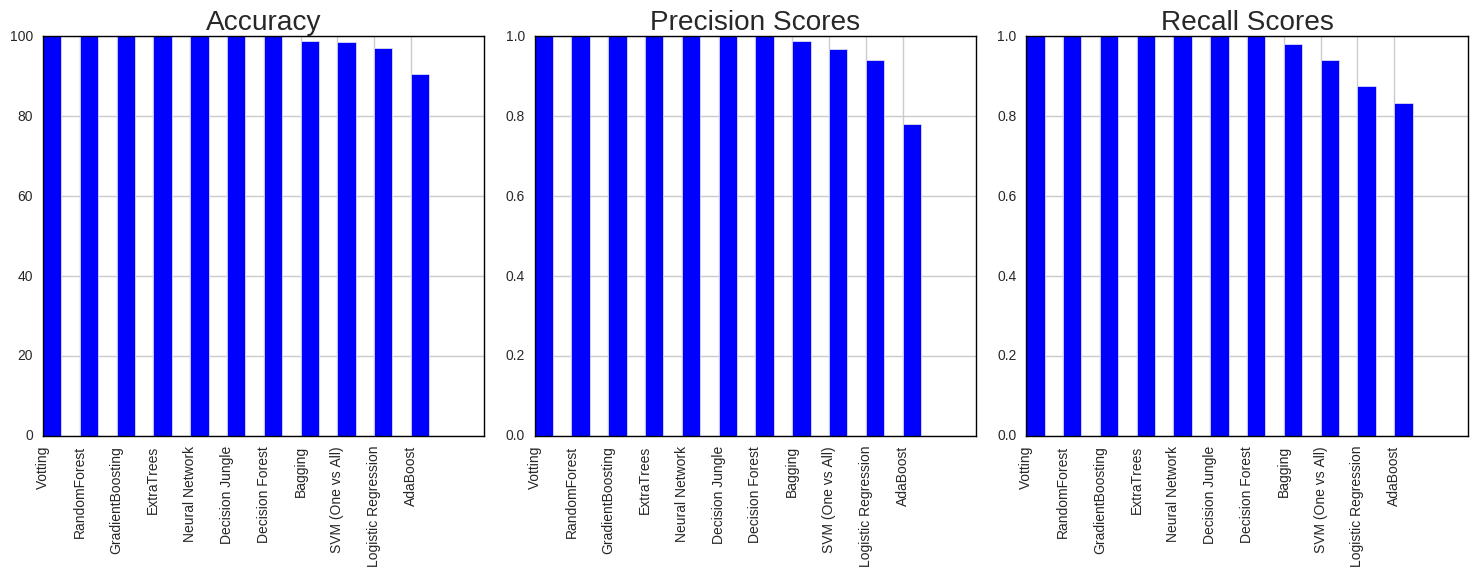

In [27]:
# Evaluate Classification Algorithms
scores_classifiers, scores_results = evaluate_algos(classifiers, X_train, Y_train, X_validation, Y_validation)
print(scores_results.sort_values(['Accuracy'], ascending=[False]))
plot_scores(scores_classifiers)

### 7.4. Evaluate Cross-Validation <a class="anchor" id="Evaluate-Cross-Validation"></a>

In [28]:
BLOBNAME= "ModelTraining/Results/CV_SummaryResults.csv"
blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME) 
dataframe_Azure_metrics = pd.read_csv(LOCALFILENAME, header=None, names=['Algorithm','type','Accuracy',
                                                                         'logloss1','Precision1','Recall1',
                                                                         'logloss2','Precision2','Recall2',
                                                                         'logloss3','Precision3','Recall3',
                                                                         'logloss4','Precision4','Recall4',
                                                                         'logloss5','Precision5','Recall5']) 

dataframe_Azure_metrics['Logloss'] = dataframe_Azure_metrics[['logloss1', 'logloss2', 'logloss3', 
                                                              'logloss4', 'logloss5']].mean(axis=1)
dataframe_Azure_metrics['Precision'] = dataframe_Azure_metrics[['Precision1', 'Precision2', 'Precision3', 
                                                              'Precision4', 'Precision5']].mean(axis=1)
dataframe_Azure_metrics['Recall'] = dataframe_Azure_metrics[['Recall1', 'Recall2', 'Recall3', 
                                                              'Recall4', 'Recall5']].mean(axis=1)

dataframe_Azure_metrics = dataframe_Azure_metrics[dataframe_Azure_metrics['type'] == 'mean'].drop(['logloss1','Precision1','Recall1','logloss2','Precision2','Recall2',
                              'logloss3','Precision3','Recall3','logloss4','Precision4','Recall4',
                              'logloss5','Precision5','Recall5'], axis=1)
print(dataframe_Azure_metrics)

            Algorithm  type  Accuracy  Logloss  Precision  Recall
0      DecisionForest  mean  100.0000   0.0125     0.9988  0.9988
2      DecisionJungle  mean  100.0000   0.0061     0.9966  0.9962
4  LogisticRegression  mean  100.0000   0.0515     1.0000  1.0000
6       NeuralNetwork  mean  100.0000   0.0361     1.0000  1.0000
8            OneVsAll  mean   98.9659   0.1447     0.9826  0.9733


                  Name  Accuracy  Logloss  Precision  Recall
1              Votting  100.0000  -0.0201     1.0000  1.0000
2         RandomForest  100.0000  -0.0001     1.0000  1.0000
3     GradientBoosting  100.0000  -0.0007     1.0000  1.0000
5           ExtraTrees  100.0000  -0.0014     1.0000  1.0000
6       DecisionForest  100.0000   0.0125     0.9988  0.9988
7       DecisionJungle  100.0000   0.0061     0.9966  0.9962
8   LogisticRegression  100.0000   0.0515     1.0000  1.0000
9        NeuralNetwork  100.0000   0.0361     1.0000  1.0000
0              Bagging   99.0942  -0.0995     0.9907  0.9829
10            OneVsAll   98.9659   0.1447     0.9826  0.9733
4             AdaBoost   88.4882  -0.3476     0.7693  0.8333


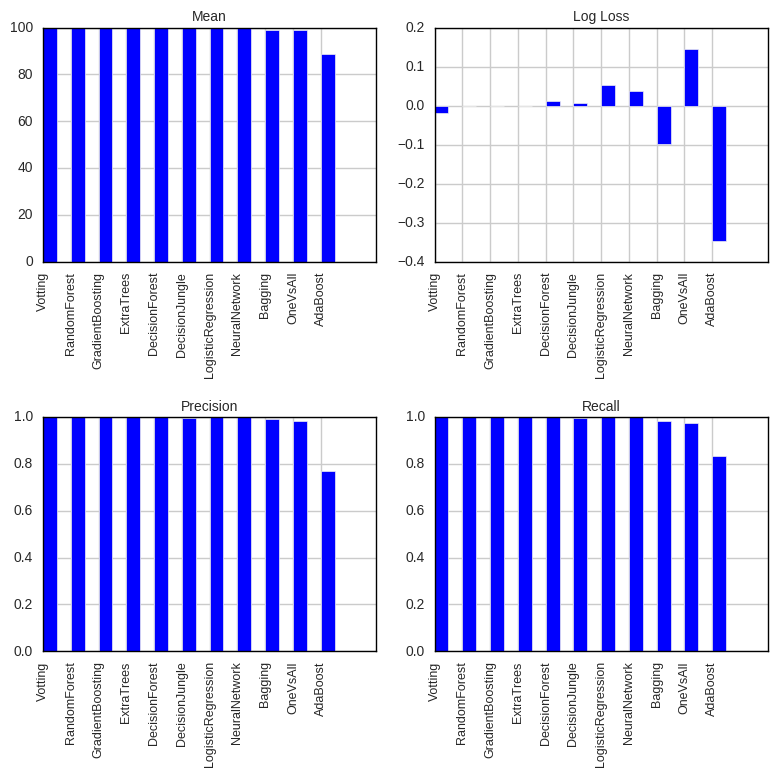

In [29]:
# Evaluate Cross-Validation
def evaluate_algos_cv(classifiers, X_train, Y_train):
    # Test options and evaluation metric
    num_folds = 10
    seed = 7
    scoring = 'accuracy'
    
    score_list = []
    metrics_list = pd.DataFrame(columns=('Name', 'Accuracy', 'Logloss', 'Precision', 'Recall'))
    
    for i, (name, algo) in enumerate(classifiers.items()):
        model = algo 

        scoring_metrics = ['accuracy', 'neg_log_loss', 'precision_macro', 'recall_macro']
        results_metrics = []
        
        metric_qty = len(scoring_metrics)
            
        for j in range(metric_qty):
            kfold = KFold(n_splits=num_folds, random_state=seed)

            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_metrics[j])
   
            results_metrics.append([cv_results.mean(), cv_results.std() * 2 * 100])
   
        score_list.append([name,  results_metrics[0][0] * 100.0, results_metrics[1][0], 
                            results_metrics[2][0], results_metrics[3][0]])
        metrics_list = metrics_list.append([{'Name': name, 'Accuracy' : results_metrics[0][0] * 100.0, 
                                           'Logloss' : results_metrics[1][0], 'Precision' : results_metrics[2][0], 
                                           'Recall' : results_metrics[3][0]}], ignore_index=True)

    # Add Azure Algorithm Scores    
    for i, row in dataframe_Azure_metrics.iterrows():
         score_list.append([row['Algorithm'], row['Accuracy'], row['Logloss'], row['Precision'], row['Recall']])
         metrics_list = metrics_list.append([{'Name': row['Algorithm'], 'Accuracy' : row['Accuracy'], 
                                           'Logloss' : row['Logloss'], 'Precision' : row['Precision'], 
                                           'Recall' : row['Recall']}], ignore_index=True)
        
    return score_list, metrics_list
    
def plot_scores_cv(score_list):      
    score_list.sort(key=lambda x: -x[1])
    names = list([item[0] for item in score_list])
    accuracy_means = list([item[1] for item in score_list])
    LogLoss_means = list([item[2] for item in score_list])
    Precision_means = list([item[3] for item in score_list])
    Recall_means = list([item[4] for item in score_list])
    idx = [i for i, _ in enumerate(names)]

    pyplot.rcParams['figure.figsize'] = [8, 8]
    
    PltNames = ['Mean', 'Log Loss','Precision','Recall']
    PltVars = [accuracy_means, LogLoss_means, Precision_means, Recall_means]
    for i in range(0,4):
        plt.subplot(2,2,i+1)
        plt.title(PltNames[i], fontsize=10)
        plt.bar(idx,PltVars[i], color = 'b', width = 0.5)
        plt.xticks(idx, names, rotation=90, fontsize=9)
    plt.tight_layout()
    plt.show()

def print_scores_cv(score_list, title):
    score_list.sort(key=lambda x: -x[1])
    names = list([item[0] for item in score_list])
    accuracy_means = list([item[1] for item in score_list])
    accuracy_stds = list([item[2] for item in score_list])
    LogLoss_means = list([item[3] for item in score_list])
    LogLoss_stds = list([item[4] for item in score_list])
    Precision_means = list([item[5] for item in score_list])
    Precision_stds = list([item[6] for item in score_list])
    Recall_means = list([item[7] for item in score_list])
    Recall_stds = list([item[8] for item in score_list])
    
    print("Name: %s" % name)
    print("Algorithm: %s" % names[0])
    print("Accuracy Mean on Training Dataset: %.2f%%" % (accuracy_means[0]))
    print("Accuracy Standard Deviation on Training Dataset: %.2f%%" % (accuracy_stds[0]))
    print("LogLoss on Training Dataset: %.2f%%" % (LogLoss_means[0]))
    print("Precision on Training Dataset: %.2f%%" % (Precision_means[0]))
    print("Recall on Training Dataset: %.2f%%" % (Recall_means[0]))
    
scores_classifiers_cv, scores_results_cv = evaluate_algos_cv(classifiers, X_train, Y_train)
print(scores_results_cv.sort_values(['Accuracy'], ascending=[False]))
plot_scores_cv(scores_classifiers_cv)

### 7.5. Evaluate Algorithm Performance <a class="anchor" id="Evaluate-Algorithm-Performance"></a>

**Algorithm results on Standardized Data**

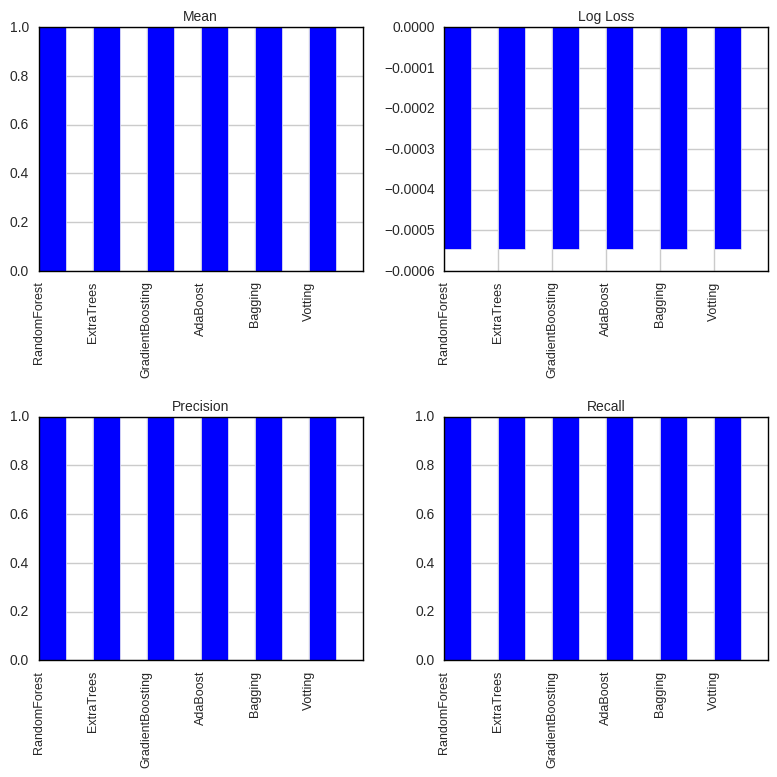

**Algorithm results on Rescaled Data**

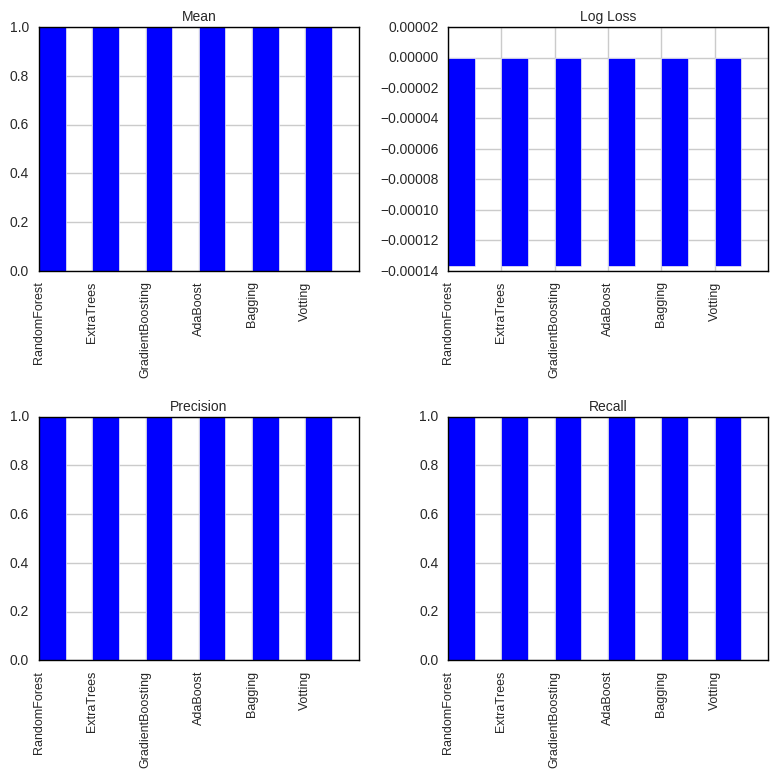

**Algorithm results on Binarized Data**

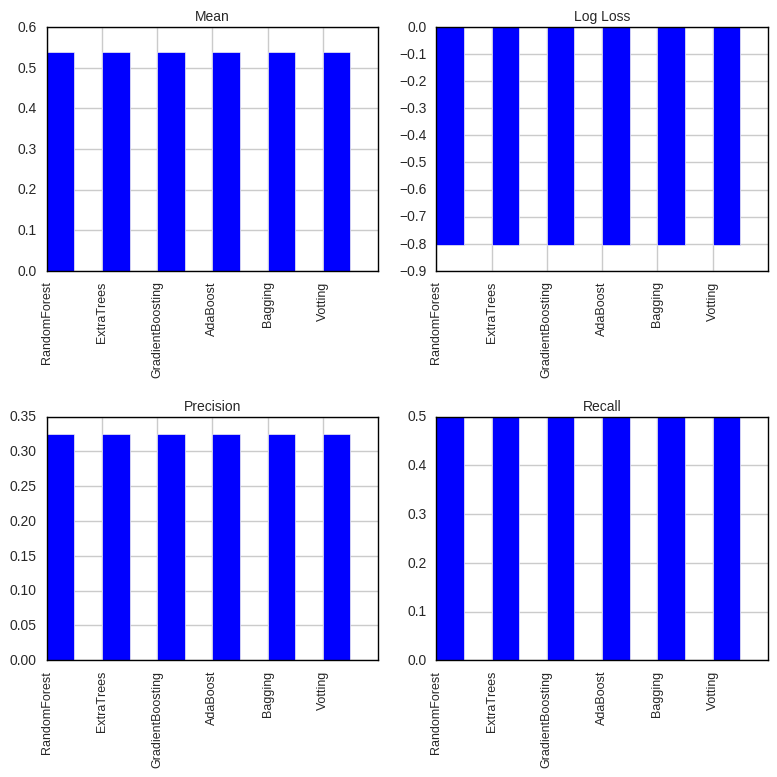

In [30]:
scalingMethods = [StandardScaler(), Normalizer(), MinMaxScaler(feature_range=(0, 1)), Binarizer(threshold=0.0)]
scalingMethodNames = ["Standardized", "Normalized", "Rescaled", "Binarized"]

for i, scalingMethod in enumerate(scalingMethods):
    # Standardise the dataset
    pipelines = []
    pipelines.append(('RandomForest', Pipeline([('Scaler', scalingMethod),('RandomForest', RandomForestClassifier())])))
    pipelines.append(('ExtraTrees', Pipeline([('Scaler', scalingMethod),('ExtraTrees', ExtraTreesClassifier())])))
    pipelines.append(('GradientBoosting', Pipeline([('Scaler', scalingMethod),('GradientBoosting', GradientBoostingClassifier())])))
    pipelines.append(('AdaBoost', Pipeline([('Scaler', scalingMethod),('AdaBoost', AdaBoostClassifier())])))
    pipelines.append(('Bagging', Pipeline([('Scaler', scalingMethod),('Bagging', BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5))])))    
    pipelines.append(('Votting', Pipeline([('Scaler', scalingMethod),('Votting', VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft'))])))
    
    score_list = []
    scoring_metrics = ['accuracy', 'neg_log_loss', 'precision_macro', 'recall_macro']
    results_metrics = []
                                           
    display(Markdown("**Algorithm results on %s Data**" % scalingMethodNames[i]))
    for name, model in pipelines:
        for j in range(len(scoring_metrics)):
            kfold = KFold(n_splits=num_folds, random_state=seed)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_metrics[j])                
            results_metrics.append([cv_results.mean(), cv_results.std() * 2 * 100])
   
        score_list.append([name, results_metrics[0][0], results_metrics[1][0], 
                               results_metrics[2][0], results_metrics[3][0]])
            
    plot_scores_cv(score_list)     

### 7.6. Test Dataset Prediction Performance <a class="anchor" id="Test-Dataset-Prediction-Performance"></a>

In [31]:
# Create a validation dataset

algos = [RandomForestClassifier()]
scalingMethods = [StandardScaler(), Normalizer(), MinMaxScaler(feature_range=(0, 1)), Binarizer(threshold=0.0)]
algoNames = ["RandomForest"]
scalingMethodNames = ["Standardized", "Normalized", "Rescaled", "Binarized"]

display(Markdown("**Accuracy Estimation of %s on validation dataset**" % algoNames[0]))

# Transformed Data
for i, scalingMethod in  enumerate(scalingMethods): 
    for j, algo in enumerate(algos):
        model = algo 
        scaler = scalingMethod.fit(X_train)
        rescaledTrainX = scaler.transform(X_train)
        model.fit(rescaledTrainX, Y_train)

        scaler = scalingMethod.fit(X_validation)
        rescaledValidationX = scaler.transform(X_validation)

        predictions = model.predict(rescaledValidationX)
        print(str(scalingMethodNames[i]) + ": " + str(accuracy_score(Y_validation, predictions)))
    print("")

**Accuracy Estimation of RandomForest on validation dataset**

Standardized: 0.90206185567

Normalized: 1.0

Rescaled: 1.0

Binarized: 0.536082474227



### 7.7. Model Tuning <a class="anchor" id="Model-Tuning"></a>

#### 7.7.1. Default Classifier Hyper-parameters

In [32]:
from pprint import pprint

rf = RandomForestClassifier()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


#### 7.7.2. Grid Search

In [33]:
# Random Forest Algorithm Tuning
param_grid = {
    'max_features': [4],
    'max_depth': [x for x in range(10,110,10)],
    'n_estimators': [x for x in range(100,210,10)],
    'min_samples_split' : [x for x in range(2,8,2)],
    'min_samples_leaf': [x for x in range(1,7,2)], 
    'bootstrap' : [True, False]
}

pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': [4],
 'min_samples_leaf': [1, 3, 5],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}


In [34]:
# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(rf, param_grid, scoring='accuracy', n_jobs=4, cv=10, verbose=0)

# Run the grid search - on only the training data!
scaler = Normalizer().fit(X_train)
rescaledTrainX = scaler.transform(X_train)
gs_cv.fit(rescaledTrainX, Y_train)

# Print the parameters that gave us the best result!
print("Best Params: %s" % gs_cv.best_params_)
print("Best Score: %s" % gs_cv.best_score_)
print("Best Estimator: %s" % gs_cv.best_estimator_)

rf_gs_best = gs_cv.best_estimator_

Best Params: {'min_samples_split': 2, 'max_depth': 10, 'n_estimators': 100, 'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 1}
Best Score: 1.0
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
